In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

Import statements and setup

In [7]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as tfhub

tf.get_logger().setLevel('ERROR')

## Visualization tools

To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [8]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


Installing object dataction API

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Now we can import the dependencies we will need later

In [10]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

##Importing the model 
Here i am using mobilenetv2 you can use any from tensorflow hub you just have to replece the link below with the link of your model.

In [11]:
model = tfhub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

Define a function to convert image into a array


In [17]:
def load_image_into_numpy_array(path):
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

Loading the image and convrting into a numpy array


In [18]:
img_path = "/content/drive/MyDrive/Colab Notebooks/GRIP/img.jpg"
image = load_image_into_numpy_array(img_path)

Visualising the image

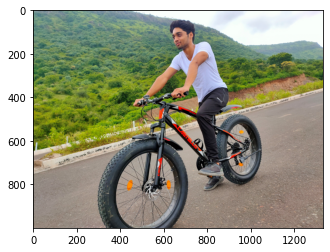

In [19]:
plt.imshow(image[0])

### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [20]:
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),(0, 2),(1, 3),(2, 4),(0, 5),(0, 6),(5, 7),(7, 9),(6, 8),(8, 10),(5, 6),(5, 11),
 (6, 12),(11, 12),(11, 13),(13, 15),(12, 14),(14, 16)]

Running inference

In [21]:
detector_output = model(image)
result = {key:value.numpy() for key,value in detector_output.items()}
print(result.keys())

dict_keys(['raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores'])


## Visualizing the results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available).

the full documentation of this method can be seen [here](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

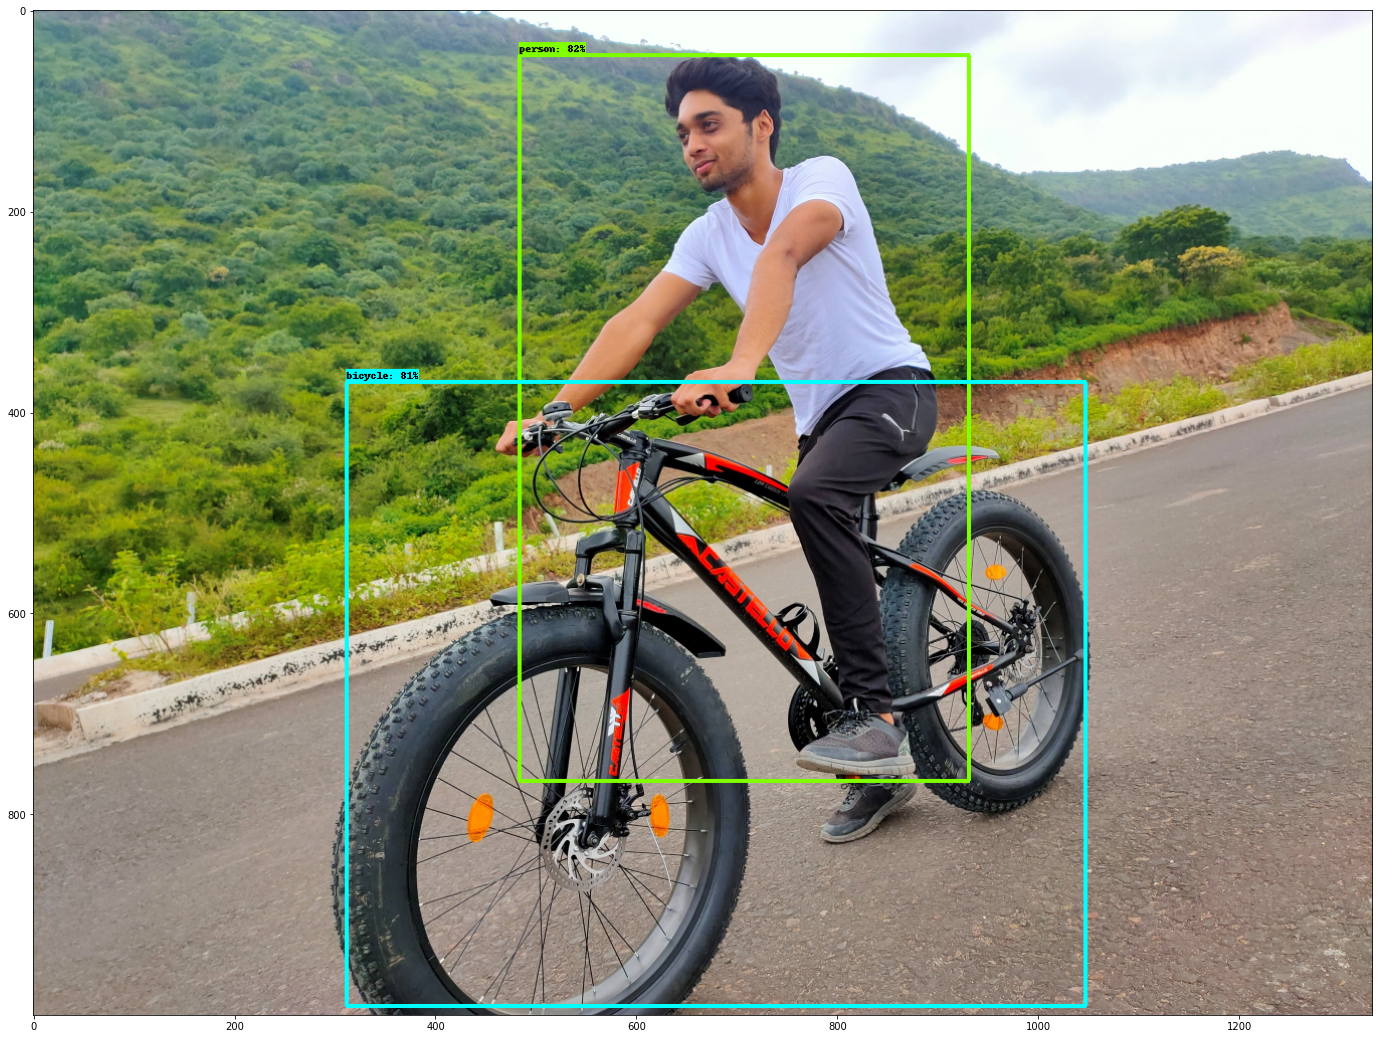

In [22]:
label_id_offset = 0
image_np_with_detections = image.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.8,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()